In [1]:
from sqlalchemy import create_engine
import pandas as pd
import configparser
import plotly.express as px
import numpy as np
from data_scripts.off_shot_chart import get_off_shot_chart
from data_scripts.def_shot_chart import get_def_shot_chart
from data_scripts.creation_play_type_shooter import get_creation_data
#pd.set_option('display.max_rows', 999)

In [2]:
config = configparser.ConfigParser()
config.read('database.ini')

# Accessing database connection details
name = config['Database']['name']
host = config['Database']['host']
username = config['Database']['username']
password = config['Database']['password']


# Create the connection string
connection_str = f'postgresql+psycopg2://{username}:{password}@{host}:5432/{name}'

# Create the SQLAlchemy engine
engine = create_engine(connection_str)

query = '''
    select p.first_name, p.last_name, pt.play_type_id, e.result_id, e.event_x, e.event_y, d.first_name as d_first_name, d.last_name as d_last_name,
    dt.type as d_type, sz.shot_zone_id, e.shot_quality_id, c.first_name as creator_first_name, c.last_name as creator_last_name, 
    cpt.play_type_id as creator_play_type,
    e.points, e.fta, e.stl_blk, t.name as team_name
    from "Events" as e
    join "Players" as p on e.player_id = p.id
    join "PlayType" as pt on e.play_type_id = pt.id
    left join "Players" as d on e.defender_id = d.id
    left join "Defense" as dt on e.defense_type_id = dt.id
    left join "Players" as c on e.creator_id = c.id
    left join "PlayType" as cpt on e.creator_play_type_id = cpt.id
    inner join "ShotZone" as sz on e.shot_zone_id = sz.id
    inner join "Teams" as t on e.team_id = t.id
'''

result = engine.execute(query)

# Fetch all rows from the query result
rows = result.fetchall()

# Get the column names from the query result
columns = result.keys()

# Create a DataFrame
data = pd.DataFrame(rows, columns=columns)

data['player_name'] = data['first_name'] + ' ' + data['last_name']
data['defender_name'] = data['d_first_name'] + ' ' + data['d_last_name']
data['creator_name'] = data['creator_first_name'] + ' ' + data['creator_last_name']
data = data.drop(columns=['first_name', 'last_name', 'd_first_name', 'd_last_name', 'creator_first_name', 'creator_last_name'])
data

play_type_id  result_id  event_x  event_y d_type shot_zone_id  \
0              CS          6     -233        5    POA        3ptZ1   
1              CS          2     -233       61    POA        3ptZ1   
2             ISO          1     -241       45    POA        3ptZ1   
3             ACO          2      -25      133    POA         SMZ2   
4             CUT          2       31       37    POA          Rim   
...           ...        ...      ...      ...    ...          ...   
2172       PNR SC          1        7       13    POA          Rim   
2173           CS          2      231       29    POA        3ptZ5   
2174       PNR BH          3       -9       21    POA          Rim   
2175           CS          2       87      141   None         LMR4   
2176           CS          1      199      149    POA        3ptZ4   

      shot_quality_id creator_play_type  points  fta  stl_blk     team_name  \
0                 NaN              None     NaN  NaN      NaN       Celtics   
1                 3.0               CUT     0.0  NaN      NaN  Timberwolves   
2                 4.0              None     3.0  NaN      NaN       Celtics   
3                 2.0              None     0.0  NaN      NaN  Timberwolves   
4                 2.0              OREB     0.0  NaN      NaN  Timberwolves   
...               ...               ...     ...  ...      ...           ...   
2172              3.0            PNR BH     2.0  NaN      NaN       Nuggets   
2173              2.0               ISO     0.0  NaN      NaN       Thunder   
2174              NaN              None     2.0  2.0      NaN       Nuggets   
2175              5.0              None     0.0  NaN      NaN       Thunder   
2176              4.0              OREB     3.0  NaN      NaN       Thunder   

                   player_name             defender_name  \
0                 Jrue Holiday                       NaN   
1     Nickeil Alexander-Walker              Jrue Holiday   
2                 Jayson Tatum  Nickeil Alexander-Walker   
3              Jaden McDaniels             Derrick White   
4              Jaden McDaniels                Al Horford   
...                        ...                       ...   
2172              Aaron Gordon   Shai Gilgeous-Alexander   
2173             Cason Wallace              Jamal Murray   
2174              Jamal Murray             Cason Wallace   
2175               Josh Giddey                       NaN   
2176             Chet Holmgren            Reggie Jackson   

                 creator_name  
0                         NaN  
1               Kyle Anderson  
2                         NaN  
3                         NaN  
4               Kyle Anderson  
...                       ...  
2172             Jamal Murray  
2173  Shai Gilgeous-Alexander  
2174                      NaN  
2175                      NaN  
2176              Josh Giddey  

[2177 rows x 15 columns]

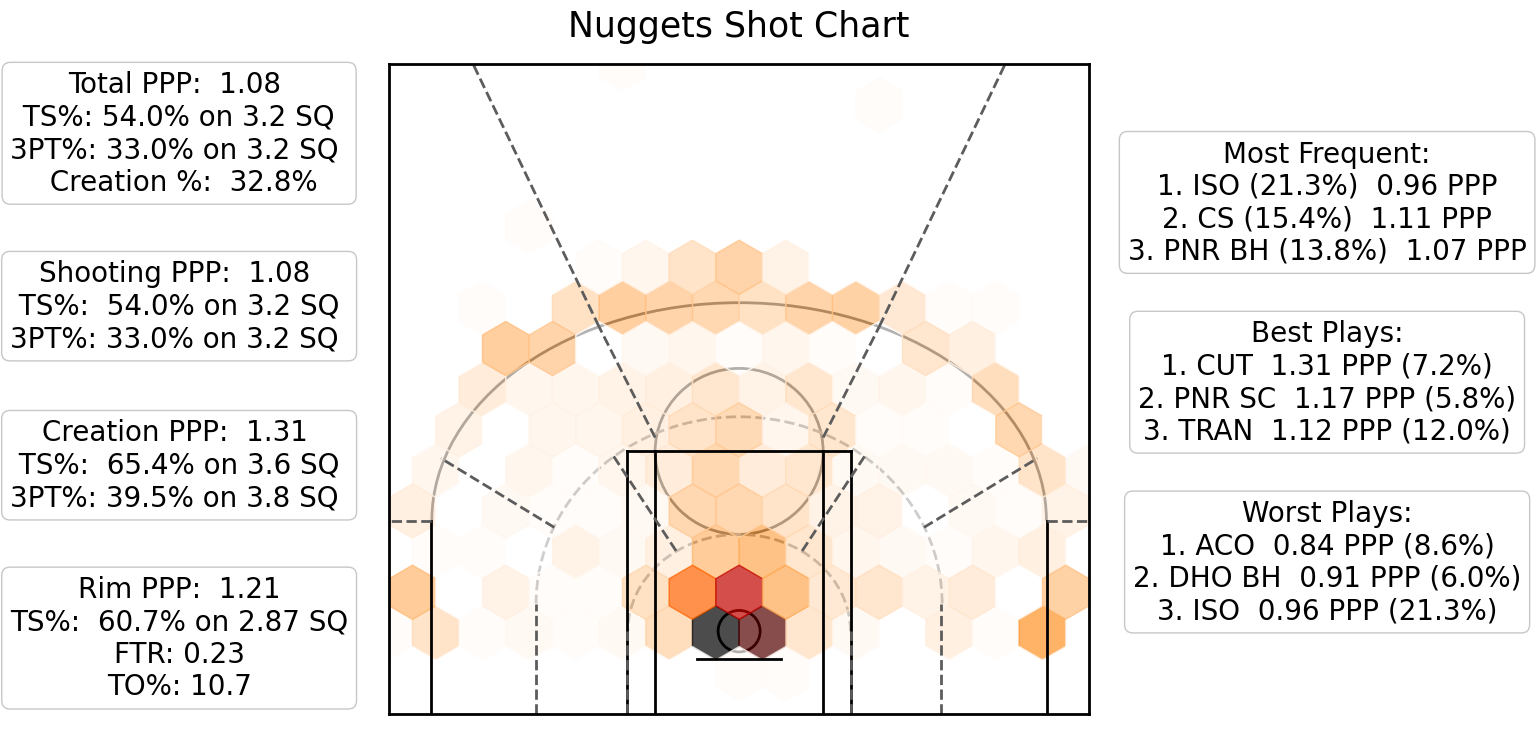

In [3]:
get_off_shot_chart('Nuggets', data, 'Shooting')

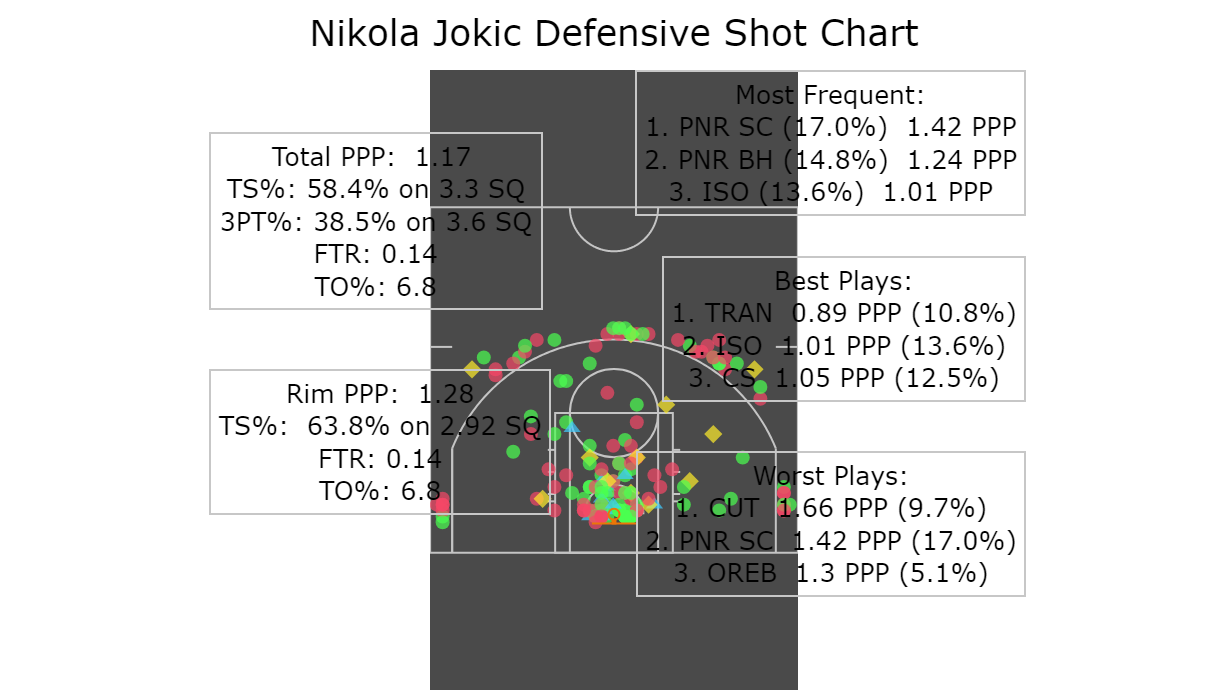

In [4]:
get_def_shot_chart('Nikola Jokic', data)

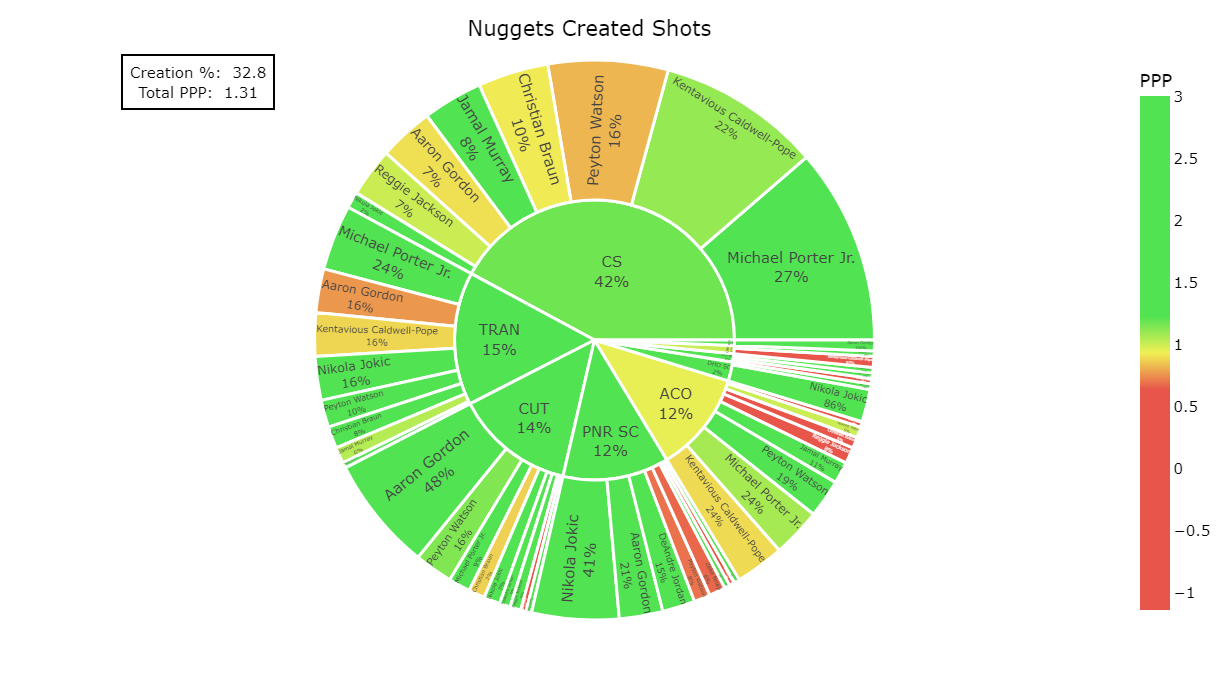

In [10]:
get_creation_data('Nuggets', data) 

In [111]:
def get_shooting_data(name, data):
    
    data = data[data['player_name'] == name]
    
    total_ppp = get_ppp(data)
    summary = f'Total PPP:  {total_ppp}<br>Assisted %:  '
    
    play_type_hash = {}
    
    for play_type in data['play_type_id']:
        
        if play_type in play_type_hash.keys():
            play_type_hash[play_type] += 1

        else:
            play_type_hash[play_type] = 1
    
    rows_list = []
    
    for play_type, count in play_type_hash.items():
        play_type_data = data[data['play_type_id'] == play_type]
        
        unassisted_count = play_type_data['creator_name'].isnull().sum()
        assisted_count = count - unassisted_count
        
        rows_list.append({'play_type_id': play_type, 'value': count, 'unassisted': unassisted_count})
        rows_list.append({'play_type_id': play_type, 'value': count, 'assisted': assisted_count})
        
        
    df = pd.DataFrame(rows_list)
    
    print(df)

    custom_colors = ["#e8554a", "#e8554a", "#e8554a", "#e8554a", "#e8554a", "#e8554a", "#e8554a",'#f0f054', "#52e352", "#52e352", "#52e352", "#52e352", "#52e352", "#52e352", "#52e352"]
    
    fig = px.sunburst(df, path=['play_type_id', 'unassisted'], values='value',
                      color_continuous_scale=custom_colors,
                      color_continuous_midpoint=0.97)
    
    fig.update_traces(textinfo='label+percent parent',
                      marker=dict(line=dict(color='white', width=3)))

    fig.update_layout(width=900, height=700, title=dict(text=f"{name} Shooting", x=0.49, y=0.97), font=dict(size=15, color='black'))
    
    fig.add_annotation(xref='paper', yref='paper', x=0.04, y=1.01, text=summary, showarrow=False, font=dict(color='black', size=15), align='center', bordercolor="black", borderwidth=2, borderpad=7,)
 
    return fig

get_shooting_data('Jamal Murray', data)

   play_type_id  value  unassisted  assisted
0          TRAN     18        15.0       NaN
1          TRAN     18         NaN       3.0
2           ISO     51        51.0       NaN
3           ISO     51         NaN       0.0
4        PNR BH     80        80.0       NaN
5        PNR BH     80         NaN       0.0
6           ACO     12         8.0       NaN
7           ACO     12         NaN       4.0
8            CS     11         0.0       NaN
9            CS     11         NaN      11.0
10       DHO BH     22        21.0       NaN
11       DHO BH     22         NaN       1.0
12          OBA      6         6.0       NaN
13          OBA      6         NaN       0.0
14          CUT      3         2.0       NaN
15          CUT      3         NaN       1.0


ValueError: ('Non-leaves rows are not permitted in the dataframe \n', play_type_id    ACO
unassisted         
Name: 7, dtype: object, 'is not a leaf.')

index play_type_id  result_id  event_x  event_y d_type shot_zone_id  \
0   1663          CUT          3      -49       37    POA          Rim   
1   1713          CUT          3        7       -3    POA          Rim   
2   1949          CUT          3      -81       77    POA         SMZ1   

   shot_quality_id creator_play_type  points  fta  stl_blk team_name  \
0              NaN              None     1.0  2.0      NaN   Nuggets   
1              NaN               ISO     0.0  2.0      NaN   Nuggets   
2              NaN              None     2.0  2.0      NaN   Nuggets   

    player_name  defender_name  creator_name  
0  Jamal Murray    Kelly Oubre           NaN  
1  Jamal Murray   Danuel House  Nikola Jokic  
2  Jamal Murray  Malik Beasley           NaN

In [12]:
def get_ppp(data):
    
    points = data['points'].sum()
    fga = data[data['result_id'].isin([1,2,4])]
    fta = data['fta'].sum()
    to = len(data[data['result_id'].isin([5,6])])
    ppp = round((points / ((len(fga)) + (0.44 * fta) + to)),2)

    return ppp

def get_freq(data):
    
    play_types_df = pd.DataFrame(columns=['play_type', 'ppp', 'freq'])
   
    for play_type in data['play_type_id'].value_counts().keys():

        ppp = get_ppp(data[data['play_type_id'] == play_type])
        count = len(data[data['play_type_id'] == play_type])
        freq = round(((count / len(data)) * 100),1)

        new_row_values = [play_type, ppp, freq]

        new_row = pd.DataFrame([new_row_values], columns=['play_type', 'ppp', 'freq'])
        play_types_df = pd.concat([play_types_df, new_row], ignore_index=True)
        
    return play_types_df

def get_ts(data):
    
    points = data['points'].sum()
    fga = data[data['result_id'].isin([1,2,4])]
    fta = data['fta'].sum()
    to = len(data[data['result_id'].isin([5,6])])
    ts = round(((points / (2 * ((len(fga) + (0.44 * fta) + to)))) * 100),1)
    
    return ts